# Model training

For this demo we'll use the freely available Statlog (German Credit Data) Data Set, which can be downloaded from [Kaggle](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). This dataset classifies customers based on a set of attributes into two credit risk groups - good or bad. The majority of the attributes in this data set are categorical, and they are symbolically encoded. For example, attribute 1 represents the status of an existing checking account and can take one of the following values:

A11 : ... < 0 DM

A12 : 0 <= ... < 200 DM

A13 : ... >= 200 DM / salary assignments for at least 1 year

A14 : no checking account

A comprehensive list of all attributes and symbol codes is given in the [document](https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc) that accompanies the original dataset. 

The data we use in this demo has also been balanced and upsampled (see the [Data Generation](./data_generation.ipynb) notebook for reference).

## Seting up and connecting to Ray


Let's start by loading all the libraries needed for the notebook and by setting up default data paths.


In [1]:
import os
import ray
import glob
import eli5

import xgboost_ray as xgbr
import xgboost as xgb
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from ray import tune

DATA_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "data") 
MODEL_ROOT = "/mnt/artifacts"
TUNE_ROOT = os.path.join("/mnt/data", os.environ["DOMINO_PROJECT_NAME"], "ray_results")

In this demo we'll use a dataset of a modest size (approx. 700 MB). Unfortunately, the standard Python libraries for data processing and machine learning Pandas and NumPy have never been designed with large datasets in mind. They rely on being able to fit the entire data in-memory with Pandas data frames having a hard theoretical limit of 100GB. In practice, the amount of data these libraries can handle is also restricted by the amount of physical memory available to the container that runs them, thus they'll have challenges handling even the 700 MB needed for our demo dataset. Trying to load our training data into a simple Pandas data frame using the code below will likely crash the Jupyter kernel.

``` 
# Do not run this code - it will likely crash the Jupyter kernel 
# (depending on the HW tier running the kernel)

import pandas as pd
import glob
import os

all_files = glob.glob(DATA_ROOT + "/train_data_*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

training_df = pd.concat(li, axis=0, ignore_index=True)
training_df.head()
```

To circumvent these restrictions Domino provides support for a number of industry-standard distributed computing frameworks like Ray, Dask, and Spark. In this demo we will use [On-Demand Ray](https://docs.dominodatalab.com/en/latest/user_guide/d13903/on-demand-ray-overview/). 

Ray is a general framework that enables you to quickly parallelize existing Python code, but it is also talked about as a "framework for building frameworks". Indeed, there are a growing number of domain-specific libraries that work on top of Ray.

![Ray](./images/ray.png)

For example:

* RaySGD - a library for distributed deep learning, which provides wrappers around PyTorch and TensorFlow
* RLlib - a library for reinforcement learning, which also natively supports TensorFlow, TensorFlow Eager, and PyTorch
* RayServe - a scalable, model-serving library
* Ray Tune - a hyperparameter optimization framework, most commonly used for deep and reinforcement learning

In this demo we'll use [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) for hyperparameter optimisation and [XGBoost on Ray](https://github.com/ray-project/xgboost_ray) for model training.

In [2]:
# We'll set up Ray for 2 workers, 4 CPUs each (12 CPUs in total, counting the head node).

RAY_ACTORS = 3
RAY_CPUS_PER_ACTOR = 4

Let's connect to Ray.

In [3]:
if ray.is_initialized() == False:
    service_host = os.environ["RAY_HEAD_SERVICE_HOST"]
    service_port = os.environ["RAY_HEAD_SERVICE_PORT"]
    ray.init(f"ray://{service_host}:{service_port}")

Let's confirm we have the expected cluster configuration.

In [4]:
ray.nodes()

[{'NodeID': '55820892afe136e0d99e4f1cbace2cc4775339e77c660a5d1368a613',
  'Alive': True,
  'NodeManagerAddress': '100.64.79.234',
  'NodeManagerHostname': 'ray-6793bf4f9cb041514b93080c-ray-head-0',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-01-24_08-27-08_985315_1/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2025-01-24_08-27-08_985315_1/sockets/raylet',
  'MetricsExportPort': 43296,
  'NodeName': '100.64.79.234',
  'alive': True,
  'Resources': {'memory': 9502472603.0,
   'object_store_memory': 4751236300.0,
   'node:100.64.79.234': 1.0}},
 {'NodeID': 'e0fe31ced74da0e9e36d0d214adbd844e7790445e69adf766da4f5cf',
  'Alive': True,
  'NodeManagerAddress': '100.64.60.51',
  'NodeManagerHostname': 'ray-6793bf4f9cb041514b93080c-ray-worker-2',
  'NodeManagerPort': 2385,
  'ObjectManagerPort': 2384,
  'ObjectStoreSocketName': '/tmp/ray/session_2025-01-24_08-27-08_985315_1/sockets/plasma_store',
  'RayletSocketName':

Now let's create a list of all the shards for our training, validation, and test sets.

In [5]:
train_files = glob.glob(os.path.join(DATA_ROOT, "train_data*"))
val_files = glob.glob(os.path.join(DATA_ROOT, "validation_data*"))

test_file = os.path.join(DATA_ROOT, "test_data.csv")

target_col = "credit"

XGBoost-Ray provides a drop-in replacement for XGBoost's train function. To pass data, instead of using xgb.DMatrix we will have to use xgboost_ray.RayDMatrix. The RayDMatrix lazy loads data and stores it sharded in the Ray object store. The Ray XGBoost actors then access these shards to run their training on. Let's wrap our training, validation, and test sets into RayDMatrix objects.

In [6]:
# Although it is possible to specify the number of Actors when initializing the RayDMatrix, it is not necessary,
#  and can cause a conflict if different from the number of Actors chosen for training.

rdm_train = xgbr.RayDMatrix(train_files, label=target_col)
rdm_val = xgbr.RayDMatrix(val_files, label=target_col)

df_test = pd.read_csv(test_file)
rdm_test = xgbr.RayDMatrix(df_test, label=target_col)

In [7]:
# This function verifies whether the data will support splitting into a given number of shards.
# We use this to validate that our splits are compatible with the selected Ray cluster configuraiton (i.e. number of Ray nodes)

rdm_train.assert_enough_shards_for_actors(len(train_files))
rdm_train.assert_enough_shards_for_actors(len(val_files))

In [8]:
print("Will the read be distributed?", rdm_train.distributed)
print("Has any data been read yet?", rdm_train.loaded) # Remember, lazy loading

Will the read be distributed? True
Has any data been read yet? False


## Model training

Let's first try to train a single model in order to validate our setup. Feel free to switch to the Ray Web UI tab and observe the distribution of workload among the individual Ray nodes.

A few things to note:

* We are using “binary:logistic” – logistic regression for binary classification (*credit* is in {0,1}), which outputs probability
* We are calculating both logloss and error as evaluation metrics. They don't impact the model fitting
* We are passing the cluster topology via the xgb_ray_params objects so that the workload can be correctly distributed


In [9]:
# Set a few hyperparameters to specific values
param = {
    "seed":1234,
    "max_depth":3,
    "eta":0.1,
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Train the model
evals_result = {}

bst = xgbr.train(
    param,
    rdm_train,
    num_boost_round=50,
    verbose_eval=True,
    evals_result=evals_result,
    evals =[(rdm_train, "train"), (rdm_val, "val")],
    ray_params=xgb_ray_params
)

print("Final training error: {:.4f}".format(evals_result["train"]["error"][-1]))
print("Final validation error: {:.4f}".format(evals_result["val"]["error"][-1]))

/opt/conda/lib/python3.9/site-packages/xgboost_ray/util.py:89: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
Use get_node_id() instead
  current_node_id = ray.get_runtime_context().node_id.hex()
(_wrapped pid=516) 2025-01-24 08:28:40,950	INFO main.py:1047 -- [RayXGBoost] Created 3 new actors (3 total actors). Waiting until actors are ready for training.
(_wrapped pid=516) 2025-01-24 08:28:47,106	INFO main.py:1092 -- [RayXGBoost] Starting XGBoost training.
(_RemoteRayXGBoostActor pid=212, ip=100.64.35.159) [08:28:47] task [xgboost.ray]:130082097689072 got new rank 0
(_RemoteRayXGBoostActor pid=171, ip=100.64.60.51) [08:28:47] task [xgboost.ray]:126207006331280 got new rank 1
(_RemoteRayXGBoostActor pid=172, ip=100.64.67.215) [08:28:47] task [xgboost.ray]:128838098260704 got new rank 2


(_wrapped pid=516) [0]	train-logloss:0.65890	train-error:0.22747	val-logloss:0.65631	val-error:0.20883
(_wrapped pid=516) [1]	train-logloss:0.63109	train-error:0.22331	val-logloss:0.62514	val-error:0.20021
(_wrapped pid=516) [2]	train-logloss:0.60870	train-error:0.22340	val-logloss:0.60081	val-error:0.20959
(_wrapped pid=516) [3]	train-logloss:0.58690	train-error:0.18629	val-logloss:0.57680	val-error:0.15792
(_wrapped pid=516) [4]	train-logloss:0.56898	train-error:0.19034	val-logloss:0.55650	val-error:0.16499
(_wrapped pid=516) [5]	train-logloss:0.55210	train-error:0.20139	val-logloss:0.53913	val-error:0.17972
(_wrapped pid=516) [6]	train-logloss:0.53646	train-error:0.18746	val-logloss:0.52258	val-error:0.16193
(_wrapped pid=516) [7]	train-logloss:0.52353	train-error:0.18899	val-logloss:0.50922	val-error:0.16659
(_wrapped pid=516) [8]	train-logloss:0.51097	train-error:0.17833	val-logloss:0.49647	val-error:0.15485
(_wrapped pid=516) [9]	train-logloss:0.50000	train-error:0.16964	val-logl

(_wrapped pid=516) 2025-01-24 08:29:17,529	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(_wrapped pid=516) [33]	train-logloss:0.34684	train-error:0.11448	val-logloss:0.33241	val-error:0.10723
(_wrapped pid=516) [34]	train-logloss:0.34377	train-error:0.11517	val-logloss:0.32920	val-error:0.10568
(_wrapped pid=516) [35]	train-logloss:0.33971	train-error:0.11360	val-logloss:0.32577	val-error:0.10412
(_wrapped pid=516) [36]	train-logloss:0.33605	train-error:0.10761	val-logloss:0.32224	val-error:0.10097
(_wrapped pid=516) [37]	train-logloss:0.33335	train-error:0.10382	val-logloss:0.31979	val-error:0.09627
(_wrapped pid=516) [38]	train-logloss:0.32945	train-error:0.10460	val-logloss:0.31619	val-error:0.09786
(_wrapped pid=516) [39]	train-logloss:0.32654	train-error:0.10505	val-logloss:0.31294	val-error:0.09787
(_wrapped pid=516) [40]	train-logloss:0.32362	train-error:0.10278	val-logloss:0.31013	val-error:0.09549
(_wrapped pid=516) [41]	train-logloss:0.32094	train-error:0.10403	val-logloss:0.30769	val-error:0.09625
(_wrapped pid=516) [42]	train-logloss:0.31872	train-error:0.1044

(_wrapped pid=516) 2025-01-24 08:29:30,655	INFO main.py:1587 -- [RayXGBoost] Finished XGBoost training on training data with total N=2,100,000 in 50.63 seconds (43.54 pure XGBoost training time).


Now that we've confirmed the pipeline we can move onto performing some hyperparameter tuning for finding an optimal model.

## Hyperparameter tuning

Hyperparameter tuning requires training many copies of a model, each with a different set of hyperparameters, and seeing which one performs the best. Each time we train a model, that is one trial. To do this in our Ray cluster, we can specify what resources to use:

* Required CPU, Memory, and/or GPU per trial
* Where to store intermediate results

The `xgboost_ray` library includes a built-in method for generating a `PlacementGroupFactory` to pass to Ray Tune, based on the `RayParams` object used for XGBoost training. Resources can also be requested in a simpler dictionary format, e.g. `{"cpu": 2.0}`. As described in the [Tune docs](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html), by default Ray Tune will schedule N concurrent trials, using 1 CPU per trial, where N is the total number of CPUs available in the cluster.

In [10]:
# Get the placement group factory to pass to Ray Tune
# Notice how the tune resources are 1 CPU greater!
xgb_tune_resources = xgb_ray_params.get_tune_resources()
print(f"We will pass a {type(xgb_tune_resources)} to Ray Tune.")
print(f"It will request {xgb_tune_resources.required_resources} per trial.")
print(f"The cluster has {ray.cluster_resources()['CPU']} CPU total.")

We will pass a <class 'ray.tune.execution.placement_groups.PlacementGroupFactory'> to Ray Tune.
It will request {'CPU': 12.0} per trial.
The cluster has 12.0 CPU total.


In [11]:
print("Saving intermediate tune results to", TUNE_ROOT)

Saving intermediate tune results to /mnt/data/Demo-Credit-Default-Model/ray_results


In this demo we will use a very simple search strategy called *a grid search*. This involves searching over a predefined grid of hyperparameter choices - and it's easy to imaging writing a simple for loop to implement it. However, for $n$ choices each of $k$ hyperparameters, a full grid search requires $O(n^k)$ trials and quickly becomes prohibitively expensive.

Ray Tune provides much more sophisticated options for optimization. Instead of pre-defining a fixed grid to search over, Ray Tune allows specifying a [search space](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-spaces) with distributions of parameters. The number of trials over the search space is specified at a later stage in the `run()` function.

In [12]:
config = {
    "seed": 1234,
    "eta": tune.loguniform(3e-3, 3e-1),
    "max_depth": tune.randint(2, 6),
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "error"]
}

For each trial, a config dictionary like the one we just defined, with the single value for each hyperparameter chosen for that trial, will be passed into a [trainable](https://docs.ray.io/en/releases-1.11.0/tune/key-concepts.html#search-algorithms) that we define and pass to Ray Tune. Below we have defined such a function to wrap training a single XGBoost model on Ray.

In [13]:
def my_trainer(config):
    evals_result = {}
    bst = xgbr.train(
        params=config,
        dtrain=rdm_train,
        num_boost_round=50,
        evals_result=evals_result,
        evals=[(rdm_train, "train"), (rdm_val, "val")],
        ray_params=xgb_ray_params
    )
    bst.save_model("model.xgb") # This will go into the TUNE_ROOT directory

Finally, we can now run our trials. Here we bring together the previous few sections:

* The training function
* The search space defined in the config
* The resources per trial and results location

We control the number of trials over the search space via the `num_samples` argument (currently set to 10). We also rank the models based on the lowest validation set error.

In [14]:
analysis = tune.run(
    my_trainer,
    config=config,
    resources_per_trial=xgb_tune_resources,
    local_dir=TUNE_ROOT,
    metric="val-error",
    mode="min",
    num_samples=10,
    verbose=1,
    progress_reporter=tune.JupyterNotebookReporter(overwrite=True)
)

(run pid=516) UserWarning: The `local_dir` argument of `Experiment is deprecated. Use `storage_path` or set the `TUNE_RESULT_DIR` environment variable instead.
(_RemoteRayXGBoostActor pid=298, ip=100.64.35.159) [08:29:54] task [xgboost.ray]:130777124524960 got new rank 0
(_RemoteRayXGBoostActor pid=251, ip=100.64.60.51) [08:29:54] task [xgboost.ray]:140313988538432 got new rank 1
(_RemoteRayXGBoostActor pid=296, ip=100.64.67.215) [08:29:54] task [xgboost.ray]:140524038161168 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.68615	train-error:0.16109	val-logloss:0.68606	val-error:0.15954
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.67934	train-error:0.16109	val-logloss:0.67923	val-error:0.15954
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.67274	train-error:0.15846	val-logloss:0.67251	val-error:0.15730
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.66628	train-error:0.15846	val-logloss:0.66590	val-error:0.15730
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.66011	train-error:0.16153	val-logloss:0.65927	val-error:0.15960
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.65409	train-error:0.15952	val-logloss:0.65281	val-error:0.15255
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.64801	train-error:0.15859	val-logloss:0.64665	val-error:0.15808
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.64223	train-error:0.15604	val-logloss:0.64040	val-error:0.14865
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:30:24,815	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.52812	train-error:0.12698	val-logloss:0.51950	val-error:0.11513
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.52461	train-error:0.12711	val-logloss:0.51584	val-error:0.11513
(my_trainer pid=252, ip=100.64.67.215) [34]	train-logloss:0.52116	train-error:0.12363	val-logloss:0.51204	val-error:0.11123
(my_trainer pid=252, ip=100.64.67.215) [35]	train-logloss:0.51777	train-error:0.12363	val-logloss:0.50853	val-error:0.11123
(my_trainer pid=252, ip=100.64.67.215) [36]	train-logloss:0.51439	train-error:0.12699	val-logloss:0.50485	val-error:0.11358
(my_trainer pid=252, ip=100.64.67.215) [37]	train-logloss:0.51106	train-error:0.12528	val-logloss:0.50135	val-error:0.11358
(my_trainer pid=252, ip=100.64.67.215) [38]	train-logloss:0.50779	train-error:0.12215	val-logloss:0.49770	val-error:0.11044
(my_trainer pid=252, ip=100.64.67.215) [39]	train-logloss:0.50442	train-error:0.12284	val-logloss:0.49427	val-error:0.10965
(my_trai

(_RemoteRayXGBoostActor pid=420, ip=100.64.35.159) [08:30:45] task [xgboost.ray]:130563786912384 got new rank 0
(_RemoteRayXGBoostActor pid=333, ip=100.64.60.51) [08:30:45] task [xgboost.ray]:124244257140896 got new rank 1
(_RemoteRayXGBoostActor pid=479, ip=100.64.67.215) [08:30:45] task [xgboost.ray]:134373157757664 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.60730	train-error:0.16109	val-logloss:0.60618	val-error:0.15954
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.54541	train-error:0.14455	val-logloss:0.53910	val-error:0.13149
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.49731	train-error:0.12886	val-logloss:0.48891	val-error:0.11901
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.45427	train-error:0.11657	val-logloss:0.44396	val-error:0.10328
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.41944	train-error:0.10466	val-logloss:0.40699	val-error:0.09314
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.38938	train-error:0.09172	val-logloss:0.37699	val-error:0.07592
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.36341	train-error:0.08994	val-logloss:0.35025	val-error:0.07510
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.34292	train-error:0.08399	val-logloss:0.32980	val-error:0.07044
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:31:16,360	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.13754	train-error:0.01876	val-logloss:0.12702	val-error:0.01255
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.13452	train-error:0.01865	val-logloss:0.12421	val-error:0.01178
(my_trainer pid=252, ip=100.64.67.215) [34]	train-logloss:0.13137	train-error:0.01708	val-logloss:0.12128	val-error:0.01099
(my_trainer pid=252, ip=100.64.67.215) [35]	train-logloss:0.12885	train-error:0.01708	val-logloss:0.11868	val-error:0.01099
(my_trainer pid=252, ip=100.64.67.215) [36]	train-logloss:0.12663	train-error:0.01708	val-logloss:0.11692	val-error:0.01099
(my_trainer pid=252, ip=100.64.67.215) [37]	train-logloss:0.12519	train-error:0.01708	val-logloss:0.11569	val-error:0.01099
(my_trainer pid=252, ip=100.64.67.215) [38]	train-logloss:0.11971	train-error:0.01561	val-logloss:0.11086	val-error:0.00943
(my_trainer pid=252, ip=100.64.67.215) [39]	train-logloss:0.11862	train-error:0.01561	val-logloss:0.10972	val-error:0.00943
(my_trai

(_RemoteRayXGBoostActor pid=502, ip=100.64.35.159) [08:31:37] task [xgboost.ray]:137053301932672 got new rank 0
(_RemoteRayXGBoostActor pid=414, ip=100.64.60.51) [08:31:37] task [xgboost.ray]:123140093354048 got new rank 1
(_RemoteRayXGBoostActor pid=701, ip=100.64.67.215) [08:31:37] task [xgboost.ray]:127375399207168 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.68831	train-error:0.20367	val-logloss:0.68812	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.68357	train-error:0.20367	val-logloss:0.68320	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.67894	train-error:0.20367	val-logloss:0.67836	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.67450	train-error:0.19528	val-logloss:0.67353	val-error:0.18459
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.67015	train-error:0.19621	val-logloss:0.66884	val-error:0.18534
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.66577	train-error:0.19528	val-logloss:0.66429	val-error:0.18459
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.66164	train-error:0.19442	val-logloss:0.65973	val-error:0.18218
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.65753	train-error:0.18939	val-logloss:0.65532	val-error:0.18228
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:32:07,861	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [29]	train-logloss:0.58288	train-error:0.17668	val-logloss:0.57508	val-error:0.15661
(my_trainer pid=252, ip=100.64.67.215) [30]	train-logloss:0.58010	train-error:0.17452	val-logloss:0.57217	val-error:0.15737
(my_trainer pid=252, ip=100.64.67.215) [31]	train-logloss:0.57733	train-error:0.17563	val-logloss:0.56915	val-error:0.16048
(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.57465	train-error:0.18073	val-logloss:0.56615	val-error:0.16127
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.57197	train-error:0.18071	val-logloss:0.56334	val-error:0.16359
(my_trainer pid=252, ip=100.64.67.215) [34]	train-logloss:0.56936	train-error:0.17687	val-logloss:0.56049	val-error:0.16279
(my_trainer pid=252, ip=100.64.67.215) [35]	train-logloss:0.56676	train-error:0.17856	val-logloss:0.55772	val-error:0.16361
(my_trainer pid=252, ip=100.64.67.215) [36]	train-logloss:0.56415	train-error:0.17732	val-logloss:0.55494	val-error:0.16361
(my_trai

(_RemoteRayXGBoostActor pid=585, ip=100.64.35.159) [08:32:34] task [xgboost.ray]:127891939226528 got new rank 0
(_RemoteRayXGBoostActor pid=538, ip=100.64.60.51) [08:32:34] task [xgboost.ray]:138990960886304 got new rank 1
(_RemoteRayXGBoostActor pid=924, ip=100.64.67.215) [08:32:34] task [xgboost.ray]:137518720754448 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.64108	train-error:0.22747	val-logloss:0.63705	val-error:0.20883
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.60239	train-error:0.22322	val-logloss:0.59368	val-error:0.20100
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.57030	train-error:0.19900	val-logloss:0.55826	val-error:0.17128
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.54575	train-error:0.18661	val-logloss:0.53145	val-error:0.15869
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.52517	train-error:0.18970	val-logloss:0.50990	val-error:0.16735
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.50668	train-error:0.17225	val-logloss:0.49173	val-error:0.15021
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.49002	train-error:0.17278	val-logloss:0.47509	val-error:0.15419
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.47379	train-error:0.16908	val-logloss:0.45936	val-error:0.14945
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:33:05,565	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [28]	train-logloss:0.30809	train-error:0.09483	val-logloss:0.29633	val-error:0.08993
(my_trainer pid=252, ip=100.64.67.215) [29]	train-logloss:0.30542	train-error:0.09315	val-logloss:0.29371	val-error:0.08914
(my_trainer pid=252, ip=100.64.67.215) [30]	train-logloss:0.30051	train-error:0.09788	val-logloss:0.28823	val-error:0.09073
(my_trainer pid=252, ip=100.64.67.215) [31]	train-logloss:0.29671	train-error:0.09158	val-logloss:0.28491	val-error:0.08607
(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.29423	train-error:0.09250	val-logloss:0.28251	val-error:0.08765
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.28987	train-error:0.09462	val-logloss:0.27857	val-error:0.08766
(my_trainer pid=252, ip=100.64.67.215) [34]	train-logloss:0.28714	train-error:0.09338	val-logloss:0.27561	val-error:0.08610
(my_trainer pid=252, ip=100.64.67.215) [35]	train-logloss:0.28323	train-error:0.09045	val-logloss:0.27121	val-error:0.08290
(my_trai

(_RemoteRayXGBoostActor pid=706, ip=100.64.35.159) [08:33:31] task [xgboost.ray]:127969826288256 got new rank 0
(_RemoteRayXGBoostActor pid=618, ip=100.64.60.51) [08:33:31] task [xgboost.ray]:131672101560912 got new rank 1
(_RemoteRayXGBoostActor pid=1109, ip=100.64.67.215) [08:33:31] task [xgboost.ray]:127177848054400 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.69102	train-error:0.20367	val-logloss:0.69094	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.68892	train-error:0.20367	val-logloss:0.68876	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.68684	train-error:0.20367	val-logloss:0.68660	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.68478	train-error:0.20367	val-logloss:0.68444	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.68274	train-error:0.20367	val-logloss:0.68232	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.68071	train-error:0.20367	val-logloss:0.68020	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.67871	train-error:0.20367	val-logloss:0.67812	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.67676	train-error:0.19554	val-logloss:0.67600	val-error:0.18925
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:34:02,080	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [26]	train-logloss:0.64273	train-error:0.18616	val-logloss:0.63921	val-error:0.17380
(my_trainer pid=252, ip=100.64.67.215) [27]	train-logloss:0.64110	train-error:0.18628	val-logloss:0.63744	val-error:0.17298
(my_trainer pid=252, ip=100.64.67.215) [28]	train-logloss:0.63942	train-error:0.18111	val-logloss:0.63569	val-error:0.16372
(my_trainer pid=252, ip=100.64.67.215) [29]	train-logloss:0.63783	train-error:0.18111	val-logloss:0.63392	val-error:0.16372
(my_trainer pid=252, ip=100.64.67.215) [30]	train-logloss:0.63617	train-error:0.18894	val-logloss:0.63217	val-error:0.17301
(my_trainer pid=252, ip=100.64.67.215) [31]	train-logloss:0.63460	train-error:0.18907	val-logloss:0.63045	val-error:0.17219
(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.63302	train-error:0.18390	val-logloss:0.62875	val-error:0.16293
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.63146	train-error:0.18390	val-logloss:0.62705	val-error:0.16293
(my_trai

(_RemoteRayXGBoostActor pid=786, ip=100.64.35.159) [08:34:35] task [xgboost.ray]:139161774179232 got new rank 0
(_RemoteRayXGBoostActor pid=699, ip=100.64.60.51) [08:34:35] task [xgboost.ray]:140234245731232 got new rank 1
(_RemoteRayXGBoostActor pid=1375, ip=100.64.67.215) [08:34:35] task [xgboost.ray]:133486363381824 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.69178	train-error:0.20367	val-logloss:0.69173	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.69043	train-error:0.20367	val-logloss:0.69032	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.68908	train-error:0.20367	val-logloss:0.68892	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.68774	train-error:0.20367	val-logloss:0.68753	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.68641	train-error:0.20367	val-logloss:0.68615	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.68509	train-error:0.20367	val-logloss:0.68477	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.68378	train-error:0.20367	val-logloss:0.68340	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.68247	train-error:0.20367	val-logloss:0.68203	val-error:0.19787
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:35:06,406	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [27]	train-logloss:0.65825	train-error:0.18724	val-logloss:0.65603	val-error:0.17994
(my_trainer pid=252, ip=100.64.67.215) [28]	train-logloss:0.65711	train-error:0.19511	val-logloss:0.65480	val-error:0.18698
(my_trainer pid=252, ip=100.64.67.215) [29]	train-logloss:0.65600	train-error:0.18905	val-logloss:0.65358	val-error:0.17998
(my_trainer pid=252, ip=100.64.67.215) [30]	train-logloss:0.65484	train-error:0.19524	val-logloss:0.65235	val-error:0.18616
(my_trainer pid=252, ip=100.64.67.215) [31]	train-logloss:0.65372	train-error:0.18905	val-logloss:0.65113	val-error:0.17998
(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.65262	train-error:0.18658	val-logloss:0.64993	val-error:0.17606
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.65151	train-error:0.18544	val-logloss:0.64872	val-error:0.17453
(my_trainer pid=252, ip=100.64.67.215) [34]	train-logloss:0.65043	train-error:0.18503	val-logloss:0.64753	val-error:0.17142
(my_trai

(_RemoteRayXGBoostActor pid=869, ip=100.64.35.159) [08:35:35] task [xgboost.ray]:133027172180032 got new rank 0
(_RemoteRayXGBoostActor pid=819, ip=100.64.60.51) [08:35:35] task [xgboost.ray]:127041894814432 got new rank 1
(_RemoteRayXGBoostActor pid=1558, ip=100.64.67.215) [08:35:35] task [xgboost.ray]:138185388683568 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.69141	train-error:0.20367	val-logloss:0.69134	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.68968	train-error:0.20367	val-logloss:0.68955	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.68797	train-error:0.20367	val-logloss:0.68777	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.68627	train-error:0.20367	val-logloss:0.68600	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.68458	train-error:0.20367	val-logloss:0.68424	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.68291	train-error:0.20367	val-logloss:0.68250	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.68125	train-error:0.20367	val-logloss:0.68076	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.67960	train-error:0.20367	val-logloss:0.67905	val-error:0.19787
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:36:06,038	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [26]	train-logloss:0.65098	train-error:0.18557	val-logloss:0.64815	val-error:0.17372
(my_trainer pid=252, ip=100.64.67.215) [27]	train-logloss:0.64958	train-error:0.18503	val-logloss:0.64663	val-error:0.17142
(my_trainer pid=252, ip=100.64.67.215) [28]	train-logloss:0.64820	train-error:0.18516	val-logloss:0.64511	val-error:0.17060
(my_trainer pid=252, ip=100.64.67.215) [29]	train-logloss:0.64682	train-error:0.18616	val-logloss:0.64362	val-error:0.17380
(my_trainer pid=252, ip=100.64.67.215) [30]	train-logloss:0.64540	train-error:0.18516	val-logloss:0.64210	val-error:0.17060
(my_trainer pid=252, ip=100.64.67.215) [31]	train-logloss:0.64405	train-error:0.18628	val-logloss:0.64063	val-error:0.17298
(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.64266	train-error:0.18616	val-logloss:0.63918	val-error:0.17380
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.64133	train-error:0.18628	val-logloss:0.63773	val-error:0.17298
(my_trai

(_RemoteRayXGBoostActor pid=992, ip=100.64.35.159) [08:36:35] task [xgboost.ray]:132411809173568 got new rank 0
(_RemoteRayXGBoostActor pid=941, ip=100.64.60.51) [08:36:35] task [xgboost.ray]:138053336142272 got new rank 1
(_RemoteRayXGBoostActor pid=1741, ip=100.64.67.215) [08:36:35] task [xgboost.ray]:127968702931152 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.62142	train-error:0.20367	val-logloss:0.61858	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.56988	train-error:0.18271	val-logloss:0.56397	val-error:0.17287
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.52991	train-error:0.17796	val-logloss:0.52126	val-error:0.16275
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.49428	train-error:0.16643	val-logloss:0.48348	val-error:0.15401
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.46704	train-error:0.16247	val-logloss:0.45380	val-error:0.14460
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.44360	train-error:0.15542	val-logloss:0.42928	val-error:0.14218
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.42243	train-error:0.14181	val-logloss:0.40675	val-error:0.13051
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.40431	train-error:0.13870	val-logloss:0.39007	val-error:0.12755
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:37:05,602	INFO main.py:1175 -- Training in progress (30 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [24]	train-logloss:0.23996	train-error:0.06233	val-logloss:0.22730	val-error:0.05481
(my_trainer pid=252, ip=100.64.67.215) [25]	train-logloss:0.23590	train-error:0.06130	val-logloss:0.22371	val-error:0.05633
(my_trainer pid=252, ip=100.64.67.215) [26]	train-logloss:0.23195	train-error:0.06141	val-logloss:0.21955	val-error:0.05557
(my_trainer pid=252, ip=100.64.67.215) [27]	train-logloss:0.22590	train-error:0.06131	val-logloss:0.21353	val-error:0.05482
(my_trainer pid=252, ip=100.64.67.215) [28]	train-logloss:0.22227	train-error:0.06232	val-logloss:0.21009	val-error:0.05562
(my_trainer pid=252, ip=100.64.67.215) [29]	train-logloss:0.21630	train-error:0.05665	val-logloss:0.20484	val-error:0.05088
(my_trainer pid=252, ip=100.64.67.215) [30]	train-logloss:0.21431	train-error:0.05961	val-logloss:0.20312	val-error:0.05405
(my_trainer pid=252, ip=100.64.67.215) [31]	train-logloss:0.21155	train-error:0.05767	val-logloss:0.20007	val-error:0.05170
(my_trai

(_RemoteRayXGBoostActor pid=1116, ip=100.64.35.159) [08:37:37] task [xgboost.ray]:136546601652816 got new rank 0
(_RemoteRayXGBoostActor pid=1062, ip=100.64.60.51) [08:37:37] task [xgboost.ray]:126201935405168 got new rank 1
(_RemoteRayXGBoostActor pid=1926, ip=100.64.67.215) [08:37:37] task [xgboost.ray]:134946320794336 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.61520	train-error:0.16109	val-logloss:0.61418	val-error:0.15954
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.55685	train-error:0.14643	val-logloss:0.55138	val-error:0.13540
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.51162	train-error:0.13538	val-logloss:0.50426	val-error:0.12685
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.47363	train-error:0.12592	val-logloss:0.46355	val-error:0.11352
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.43933	train-error:0.11411	val-logloss:0.42852	val-error:0.10094
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.41068	train-error:0.10837	val-logloss:0.39967	val-error:0.09627
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.38553	train-error:0.10009	val-logloss:0.37313	val-error:0.09311
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.36513	train-error:0.09680	val-logloss:0.35235	val-error:0.09009
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:38:08,358	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [30]	train-logloss:0.15301	train-error:0.02529	val-logloss:0.14425	val-error:0.01722
(my_trainer pid=252, ip=100.64.67.215) [31]	train-logloss:0.15137	train-error:0.02327	val-logloss:0.14252	val-error:0.01644
(my_trainer pid=252, ip=100.64.67.215) [32]	train-logloss:0.14804	train-error:0.02053	val-logloss:0.13931	val-error:0.01485
(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.14454	train-error:0.01952	val-logloss:0.13552	val-error:0.01328
(my_trainer pid=252, ip=100.64.67.215) [34]	train-logloss:0.14287	train-error:0.01897	val-logloss:0.13392	val-error:0.01406
(my_trainer pid=252, ip=100.64.67.215) [35]	train-logloss:0.13821	train-error:0.01423	val-logloss:0.12928	val-error:0.01017
(my_trainer pid=252, ip=100.64.67.215) [36]	train-logloss:0.13414	train-error:0.01400	val-logloss:0.12505	val-error:0.00937
(my_trainer pid=252, ip=100.64.67.215) [37]	train-logloss:0.13274	train-error:0.01400	val-logloss:0.12369	val-error:0.00937
(my_trai

(_RemoteRayXGBoostActor pid=1241, ip=100.64.35.159) [08:38:30] task [xgboost.ray]:132895548621488 got new rank 0
(_RemoteRayXGBoostActor pid=1143, ip=100.64.60.51) [08:38:30] task [xgboost.ray]:131180322345552 got new rank 1
(_RemoteRayXGBoostActor pid=2148, ip=100.64.67.215) [08:38:30] task [xgboost.ray]:124939974233968 got new rank 2


(my_trainer pid=252, ip=100.64.67.215) [0]	train-logloss:0.68865	train-error:0.20367	val-logloss:0.68847	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [1]	train-logloss:0.68424	train-error:0.20367	val-logloss:0.68389	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [2]	train-logloss:0.67992	train-error:0.20367	val-logloss:0.67937	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [3]	train-logloss:0.67568	train-error:0.20367	val-logloss:0.67497	val-error:0.19787
(my_trainer pid=252, ip=100.64.67.215) [4]	train-logloss:0.67160	train-error:0.19304	val-logloss:0.67055	val-error:0.18065
(my_trainer pid=252, ip=100.64.67.215) [5]	train-logloss:0.66761	train-error:0.19528	val-logloss:0.66623	val-error:0.18459
(my_trainer pid=252, ip=100.64.67.215) [6]	train-logloss:0.66373	train-error:0.19442	val-logloss:0.66196	val-error:0.18218
(my_trainer pid=252, ip=100.64.67.215) [7]	train-logloss:0.65988	train-error:0.19621	val-logloss:0.65780	val-error:0.18534
(my_trainer pid=

(my_trainer pid=252, ip=100.64.67.215) 2025-01-24 08:39:00,867	INFO main.py:1175 -- Training in progress (31 seconds since last restart).


(my_trainer pid=252, ip=100.64.67.215) [33]	train-logloss:0.57849	train-error:0.17744	val-logloss:0.57025	val-error:0.15893
(my_trainer pid=252, ip=100.64.67.215) [34]	train-logloss:0.57597	train-error:0.17937	val-logloss:0.56761	val-error:0.16204
(my_trainer pid=252, ip=100.64.67.215) [35]	train-logloss:0.57350	train-error:0.17981	val-logloss:0.56486	val-error:0.16203
(my_trainer pid=252, ip=100.64.67.215) [36]	train-logloss:0.57101	train-error:0.17778	val-logloss:0.56227	val-error:0.15973
(my_trainer pid=252, ip=100.64.67.215) [37]	train-logloss:0.56861	train-error:0.17697	val-logloss:0.55962	val-error:0.16052
(my_trainer pid=252, ip=100.64.67.215) [38]	train-logloss:0.56624	train-error:0.17982	val-logloss:0.55706	val-error:0.16283
(my_trainer pid=252, ip=100.64.67.215) [39]	train-logloss:0.56389	train-error:0.17776	val-logloss:0.55464	val-error:0.16285
(my_trainer pid=252, ip=100.64.67.215) [40]	train-logloss:0.56145	train-error:0.17890	val-logloss:0.55219	val-error:0.16441
(my_trai

(run pid=516) 2025-01-24 08:39:17,422	INFO tune.py:945 -- Total run time: 586.10 seconds (570.52 seconds for the tuning loop).


Ray Tune returns an `ExperimentAnalysis` object which contains the results of the trials. We are only interested in its `best_config` property, which provides information on the best performing trial (according to our evaluation criteria).

In [15]:
analysis.best_config

{'seed': 1234,
 'eta': 0.1593573897650846,
 'max_depth': 5,
 'objective': 'binary:logistic',
 'eval_metric': ['logloss', 'error']}

We now have the hyperparameters (*depth* and *learing rate*) that produce the best model. Luckily, we don't have to use them to train it from scratch as our training function automatically persists each attempted model. All we need to do now is to move the already trained variant to `/mnt` and ignore the others. We'll name the selected model `tune_best.xgb`.

In [16]:
import shutil

shutil.copy(
    os.path.join(analysis.best_logdir, "model.xgb"),
    os.path.join(MODEL_ROOT, "tune_best.xgb")
)

'/mnt/artifacts/tune_best.xgb'

Recall, that the model was selected using a validation set. We don't know its actual generalisation capability until we measure it on the test set.
Let's go ahead and test how well it performs on unseen data. Note, that here we are also using Ray for the inference. This is not necessary. Later you will see that we can just unpickle the model and use standard XGBoost for the purposes of operationalisation.

In [17]:
# Inference using Ray

# Load the serialized model
bst = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))


xgb_ray_params = xgbr.RayParams(
    num_actors=RAY_ACTORS,
    cpus_per_actor=RAY_CPUS_PER_ACTOR
)

# Make predictions on the test data
predictions = xgbr.predict(bst, rdm_test, ray_params=xgb_ray_params)
pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

(predict pid=516) 2025-01-24 08:39:17,570	INFO main.py:1632 -- [RayXGBoost] Created 3 remote actors.
(predict pid=516) 2025-01-24 08:39:19,529	INFO main.py:1649 -- [RayXGBoost] Starting XGBoost prediction.


Accuracy on test: 0.68


In [18]:
list(predictions)

[0.5038057,
 0.9779327,
 0.50136465,
 0.9894806,
 0.9944898,
 0.67633533,
 0.608611,
 0.8452473,
 0.8991361,
 0.5731031,
 0.944325,
 0.45365113,
 0.90964913,
 0.8749576,
 0.3362398,
 0.33812937,
 0.9248749,
 0.7734659,
 0.9134943,
 0.8899548,
 0.47230527,
 0.954635,
 0.40130213,
 0.9956892,
 0.5653552,
 0.9495841,
 0.23981372,
 0.3795244,
 0.9698645,
 0.16447823,
 0.9809559,
 0.14212269,
 0.699508,
 0.9667574,
 0.93069744,
 0.44893438,
 0.99926096,
 0.96004474,
 0.8346362,
 0.91143185,
 0.22115591,
 0.97544926,
 0.4556924,
 0.28870058,
 0.8551148,
 0.43068767,
 0.9840857,
 0.76902646,
 0.5982689,
 0.98527026,
 0.9181259,
 0.99248827,
 0.91243607,
 0.9883786,
 0.9557416,
 0.035346836,
 0.97944343,
 0.84241116,
 0.963085,
 0.99489367,
 0.67678165,
 0.8313136,
 0.6713319,
 0.50136465,
 0.9126385,
 0.8209844,
 0.89794016,
 0.2496235,
 0.16548613,
 0.65567654,
 0.98102486,
 0.34411606,
 0.50393194,
 0.99800295,
 0.9189569,
 0.9168098,
 0.59881085,
 0.28527114,
 0.97908396,
 0.8805017,
 0.88

## Model explainability

The interest in interpretation of machine learning has been rapidly accelerating in the last decade. This can be attributed to the popularity that machine learning algorithms, and more specifically deep learning, has been gaining in various domains.

According to Fox et al. (2017), the need for explainable AI is mainly motivated by the following three reasons:

* The need for **trust** - if a doctor is recommending a treatment protocol based on a prediction from a neural network, this doctor must have absolute trust in the network's capability. This trust must be paramount when human lives are at stake.
* The need for **interaction** - complex decision making systems often rely on Human–Autonomy Teaming (HAT), where the outcome is produced by joint efforts of one or more humans and one or more autonomous agents. This form of cooperation requires that the human operator is able to interact with the model for the purposes of better understanding or improving the automated recommendations.
* The need for **transparency** - if a network makes an inappropriate recommendation or disagrees with a human expert, its behaviour must be explainable. There should be mechanisms that allow us to inspect the inner workings of the model's decision making process and get insight on what this decision was based on.

In addition, regulators are introducing legal requirements around the use of automated decision making. For example, [article 22 of the General Data Protection Regulation](https://gdpr-info.eu/art-22-gdpr/) (GDPR) introduces the right of explanation - the power of an individual to demand an explanation on the reasons behind a model-based decision and to challenge the decision if it leads to a negative impact for the individual. The Defence Advanced Research Projects Agency (DARPA) in the US is supporting a major effort that seeks to facilitate AI explainability (see Turek, DARPA XAI).

In this section of the notebook, we'll look into interpreting the inner workings of the model to better understand the encoded inductive biases.

Let's begin by loading the model as a normal XGBoost model. We are no longer using Ray, as the model itself and the inference don't process large amounts of data.

We'll also run another accuracy calculation on the test set (this time using a pure Pandas data frame) and make sure that the numbers agree.

In [19]:
xgc = xgb.Booster(model_file=os.path.join(MODEL_ROOT, "tune_best.xgb"))
df_test_X = df_test.drop(target_col, axis=1)
xgtest = xgb.DMatrix(df_test_X)

predictions = xgc.predict(xgtest)

pred_class = (predictions > 0.5).astype("int") 
actuals = df_test[target_col]
print("Accuracy on test: {:.2f}".format(accuracy_score(pred_class, actuals)))

Accuracy on test: 0.68


Generally speaking, feature importance quantifies how useful each feature was in the construction of the model. We can interrogate a fitted XGBoost model on the feature importance and get the numbers for each one of the individual features.

Indirectly, this tells us how much each feature contributes to the model predictions. There is a method called `plot_importance`, which. plots the attribute importance based on the fitted trees. This method accepts an argument named `importance_type`, which takes one of the following values and controls how importance is calculated:

* gain --- average gain of splits which use the feature. When looking at two features, the one with the higher gain is more important for generating a prediction. Typically, Gain is the most relevant attribute to interpret the relative importance of each feature.
* weight --- number of times a feature appears in a tree. 
* cover --- average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split. This basically gives us the relative number of observations related to a feature.

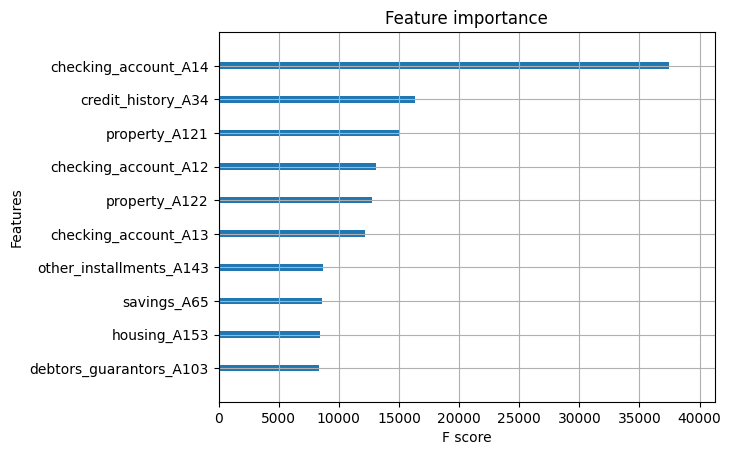

In [20]:
xgb.plot_importance(xgc, importance_type="gain", max_num_features=10, show_values=False);

Based on the above we see that the top three features driving the predictions of the model are:

* checking_account_A14 - lack of a checking account
* credit_history_A34 - critical account / has credits outside of the bank
* property_A121 - real estate

We could also look at the other importance metrics, just for completeness.

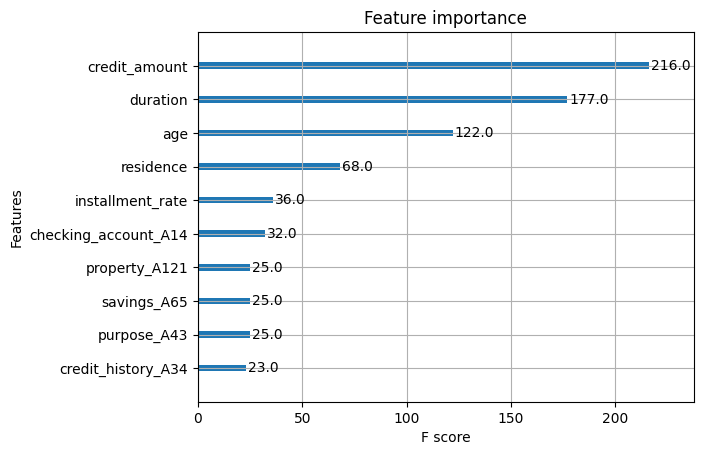

In [21]:
xgb.plot_importance(xgc, importance_type="weight", max_num_features=10);

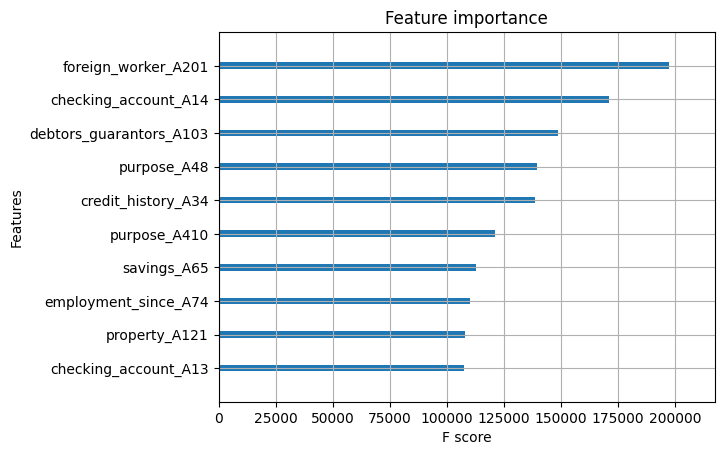

In [22]:
xgb.plot_importance(xgc, importance_type="cover", max_num_features=10, show_values=False);

ELI5 is another popular libarary for model explainability. This package is used to debug machine learning classifiers and explain their predictions. 

Unlike XGBoost, which is confined to explaining its own models only, ELI5 provides support for other frameworks like *scikit-learn*, *Keras*, *LightGBM* and others. It can also explain black-box models (i.e. Neural Networks) using [LIME](https://www.dominodatalab.com/blog/explaining-black-box-models-using-attribute-importance-pdps-and-lime).

First, ELI5 also provides a way of calculating the feature importance. Let's test it and make sure it agrees with the original XGBoost calculation (based on gain).

In [23]:
eli5.show_weights(xgc)

Weight,Feature
0.1084,checking_account_A14
0.0473,credit_history_A34
0.0434,property_A121
0.0378,checking_account_A12
0.0368,property_A122
0.0351,checking_account_A13
0.0251,other_installments_A143
0.0248,savings_A65
0.0245,housing_A153
0.0243,debtors_guarantors_A103


A more interesting function is `show_predictions`, which returns an explanation of the decision behind individual predictions. In other words, we can see what features drove the model to predict one outcome or the other.

Feel free to experiment with the code below, changing the `id` value and observing what features the model uses to calculate its prediction, and if the prediction agrees with the actual value. The `id` variable represents an observation number from the test dataset.

In [24]:
id = 3 # <- change this to see results for different observations  

print("Actual Label: %s" % actuals.iloc[id])
print("Predicted: %s" % pred_class[id])
eli5.show_prediction(xgc, df_test_X.iloc[id], 
                     feature_names=list(df_test_X.columns),
                     show_feature_values=True)


Actual Label: 1
Predicted: 1


This concludes the model training notebook demo.

In [25]:
# Set some default values
column_names_all = ['duration', 'credit_amount', 'installment_rate', 'residence', 'age', 'credits', 'dependents', 'checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 'credit_history_A30', 'credit_history_A31',
                    'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                    'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 'status_A91', 'status_A92', 'status_A93', 'status_A94', 
                    'debtors_guarantors_A101', 'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 'other_installments_A143', 'housing_A151', 
                    'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']

sample_data = [[0.4705882352941176, 0.3685484758446132, 0.3333333333333333, 0.3333333333333333, 
                0.2857142857142857, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 
                1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0]]

In [26]:
df_all = pd.DataFrame(sample_data, columns=column_names_all)

In [27]:
for col in ['checking_account_A11', 'checking_account_A12', 'checking_account_A13', 'checking_account_A14', 
                'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 
                'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 
                'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 
                'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_since_A71', 
                'employment_since_A72', 'employment_since_A73', 'employment_since_A74', 'employment_since_A75', 
                'status_A91', 'status_A92', 'status_A93', 'status_A94', 'debtors_guarantors_A101', 
                'debtors_guarantors_A102', 'debtors_guarantors_A103', 'property_A121', 'property_A122', 
                'property_A123', 'property_A124', 'other_installments_A141', 'other_installments_A142', 
                'other_installments_A143', 'housing_A151', 'housing_A152', 'housing_A153', 'job_A171', 'job_A172', 
                'job_A173', 'job_A174', 'telephone_A191', 'telephone_A192', 'foreign_worker_A201', 'foreign_worker_A202']:
    df_all[col] = df_all[col].astype('int')


In [28]:
eli5.show_prediction(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns),
                         show_feature_values=True)

In [29]:
df_all.iloc[0]

duration               0.470588
credit_amount          0.368548
installment_rate       0.333333
residence              0.333333
age                    0.285714
                         ...   
job_A174               1.000000
telephone_A191         0.000000
telephone_A192         1.000000
foreign_worker_A201    1.000000
foreign_worker_A202    0.000000
Name: 0, Length: 61, dtype: float64

In [30]:
df_all.iloc[0]["checking_account_A14"]

0.0

In [31]:
df_prediction = eli5.explain_prediction_df(xgc, df_all.iloc[0], 
                         feature_names=list(df_all.columns))

In [32]:
df_prediction.head(10).style.background_gradient(cmap = "Greens").hide()

target,feature,weight,value
y,purpose_A41,0.972699,1.000000
y,credit_amount,0.704169,0.368548
y,age,0.412246,0.285714
y,installment_rate,0.137118,0.333333
y,property_A123,0.125917,1.000000
y,employment_since_A73,0.124115,1.000000
y,status_A93,0.095267,1.000000
y,employment_since_A72,0.069451,0.000000
y,telephone_A192,0.065084,1.000000
y,job_A173,0.058622,0.000000
